#Introduction



1) Indicators

2) model.py

3) signal_engine

4) backtest

5) utils

In [ ]:
import pandas as pd
import numpy as np

# Indicators

**EMA 200** and **RSI (14)** combination was selected based on the results of the backtesting performed on the spot price data.

Backtesting was done under three different conditions:
1. **No restrictions** – No stop loss, take profit, or end-of-day exit.
2. **Partial restriction** – With stop loss and take profit, but no end-of-day exit.
3. **Full restriction** – With stop loss, take profit, and end-of-day exit.

### Combinations Tested:
1. EMA 200, RSI(14)
2. EMA 200, EMA(50)

After testing, **EMA 200 and RSI(14)** was selected because it showed **stable returns** even under restricted trading conditions.

---

### To Check the Backtest for in detail Results

Open the `Indicators.ipynb` notebook or click the Colab link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1rR9yP8suWtUSA_hunmYQXBPlc50u_ex9?usp=sharing)



#Importing data for LSTM

In [ ]:
df=pd.read_csv('/content/spot_with_signals_2023.csv')

In [ ]:
df.head()

datetime      open      high       low     close  \
0  2023-01-02 09:20:00+05:30  18131.70  18150.15  18117.55  18141.35   
1  2023-01-02 09:21:00+05:30  18142.20  18145.70  18131.40  18135.65   
2  2023-01-02 09:22:00+05:30  18133.25  18140.55  18120.65  18140.55   
3  2023-01-02 09:23:00+05:30  18139.40  18139.40  18120.15  18130.75   
4  2023-01-02 09:24:00+05:30  18130.30  18133.55  18113.05  18113.10   

  closest_expiry        ap       esa      d     ci    tci    wt1    wt2  \
0     2023-01-05  18125.43  18129.07  23.75 -10.22 -53.39 -53.39 -57.78   
1     2023-01-05  18125.43  18129.07  23.75 -10.22 -53.39 -53.39 -57.78   
2     2023-01-05  18125.43  18129.07  23.75 -10.22 -53.39 -53.39 -57.78   
3     2023-01-05  18125.43  18129.07  23.75 -10.22 -53.39 -53.39 -57.78   
4     2023-01-05  18125.43  18129.07  23.75 -10.22 -53.39 -53.39 -57.78   

     rsi  cross signal  
0  39.45    NaN   Hold  
1  39.45    NaN   Hold  
2  39.45    NaN   Hold  
3  39.45    NaN   Hold  
4  39.45    NaN   Hold

## 📈 LSTM Model for Next-Day Close Price Prediction

The **LSTM model** is used to predict the **next day's close price** based on historical spot data.

Once predictions are made, they are stored in a new column called `predicted_close`.

This column is then **merged with the original spot dataset** using the `datetime` column as the key.

The **merged dataset** is used for generating signals and further backtesting of the strategy.

---

### 🔁 Workflow

1. Train LSTM model on historical spot data.
2. Predict next day's close price.
3. Store predictions in a new column `predicted_close`.
4. Merge this column with the original spot dataset.
5. Use the updated dataset for signal generation and backtesting.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Step 1: Load and preprocess
df = pd.read_csv('/content/spot_with_signals_2023.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.sort_values('datetime', inplace=True)

# Scale close prices
scaler = MinMaxScaler()
df['scaled_close'] = scaler.fit_transform(df[['close']])

# Step 2: Create sequences of 63 timesteps
def create_sequences(data, seq_len=63):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_len = 63
X, y = create_sequences(df['scaled_close'].values, seq_len)

# Reshape for LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))
y = y.reshape(-1, 1)

# Step 3: Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 4: Build model
model = Sequential([
    LSTM(10, input_shape=(seq_len, 1), name='lstm_layer'),
    Dense(1, name='output')
])

from tensorflow import keras
optimizer = keras.optimizers.RMSprop(learning_rate=0.001,
                                     rho=0.9,
                                     epsilon=1e-08,
                                     decay=0.0)

model.compile(loss='mean_squared_error', optimizer=optimizer)

# Step 5: Train with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=25,
          batch_size=32,
          callbacks=[early_stopping],
          verbose=1)

# Step 6: Predict
pred_scaled = model.predict(X)
pred_close = scaler.inverse_transform(pred_scaled)

# Step 7: Align predictions with original dataframe
# Pad the first 63 rows with NaNs (no predictions for them)
pred_full = np.full((len(df),), np.nan)
pred_full[seq_len:] = pred_close.flatten()

df['prediction'] = pred_full

# Step 8: Save to CSV
df.to_csv('spot_predictions_output.csv', index=False)

print("✅ Predictions saved to 'lstm_predictions_output.csv'")

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


2271/2271 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0023 - val_loss: 4.0469e-04
Epoch 2/25
2271/2271 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 3.4228e-05 - val_loss: 2.7706e-04
Epoch 3/25
2271/2271 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 2.6213e-05 - val_loss: 4.8531e-05
Epoch 4/25
2271/2271 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 2.1703e-05 - val_loss: 1.3156e-04
Epoch 5/25
2271/2271 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 1.9038e-05 - val_loss: 9.8441e-05
Epoch 6/25
2271/2271 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 1.6706e-05 - val_loss: 6.2421e-05
Epoch 7/25
2271/2271 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 1.4792e-05 - val_loss: 7.2303e-05
Epoch 8/25
2271/2271 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 1.3608e-05 - val_loss: 1.1914e-04
Epoch 9/25
2271/2271 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 1.2615e-05 - val_loss: 2.4313e-05
Epoch 10/25
2271/2271 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 1.1755e-05 - val_loss: 6.3645e-05
Epoch 11/25
2271/2271 ━━━━━━━━━━━━━━━━━━━━ 2

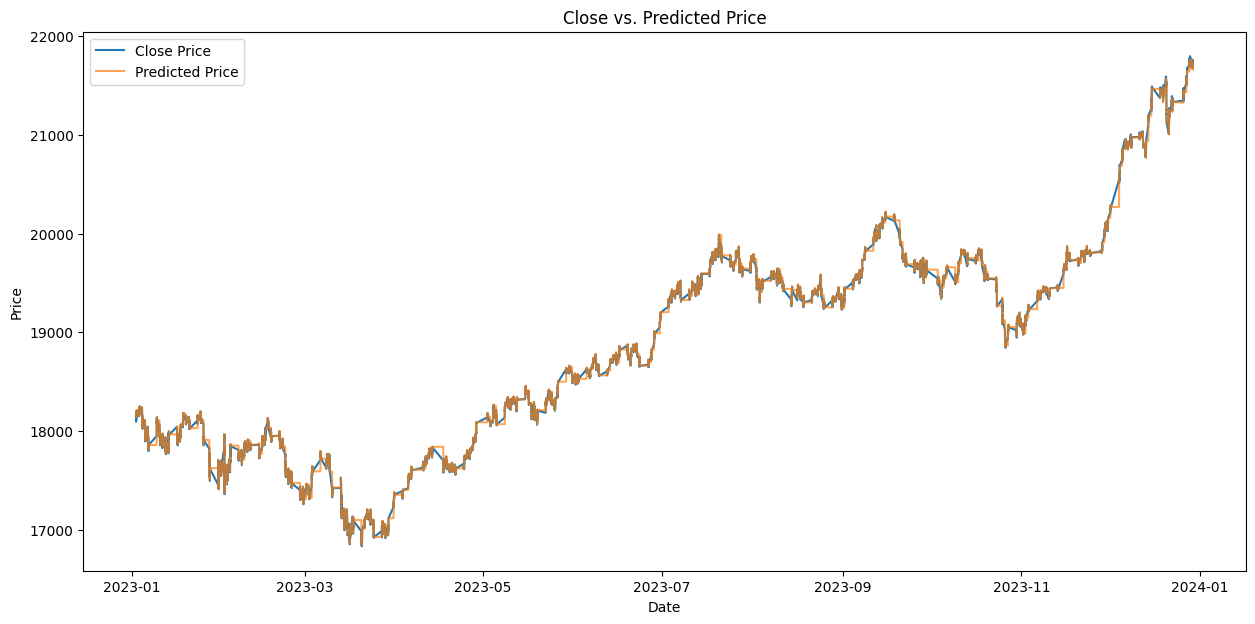

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(df['datetime'], df['close'], label='Close Price')
plt.plot(df['datetime'], df['prediction'], label='Predicted Price', alpha=0.7)
plt.title('Close vs. Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Loss Over Epochs – Summary

The graph shows **Training** (blue) and **Validation** (orange) **Mean Squared Error (MSE)** loss over 25 epochs for a regression model.

### Key Observations:

- **Initial Phase (Epoch 0):**
  - Loss starts high (~0.0004), indicating large prediction errors on an untrained model.

- **Rapid Learning (Epochs 0–3):**
  - Sharp drop in both losses shows the model quickly learns useful patterns.

- **Stabilization (Epochs 5–25):**
  - Training loss steadily decreases.
  - Validation loss remains low with slight fluctuations, suggesting good generalization.

- **No Overfitting:**
  - Both curves stay close and low throughout, indicating minimal overfitting.

### Interpretation:

- The model is well-optimized with **strong generalization** and **low bias-variance tradeoff**.
- The MSE loss curve suggests effective and stable training.

### Conclusion:

The learning curve indicates a successful training process with fast convergence and reliable performance on unseen data.


2271/2271 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
568/568 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

📊 Evaluation Metrics:
✅ Train RMSE: 8.460409
✅ Train MAE : 6.362581
✅ Test RMSE : 12.057160
✅ Test MAE  : 8.901652


/tmp/ipython-input-13-1833529725.py:36: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


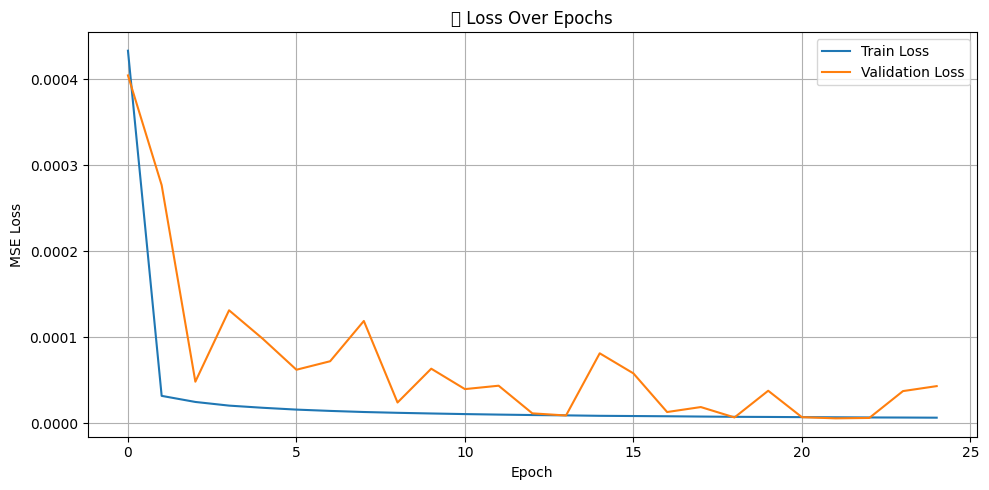

/tmp/ipython-input-13-1833529725.py:48: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


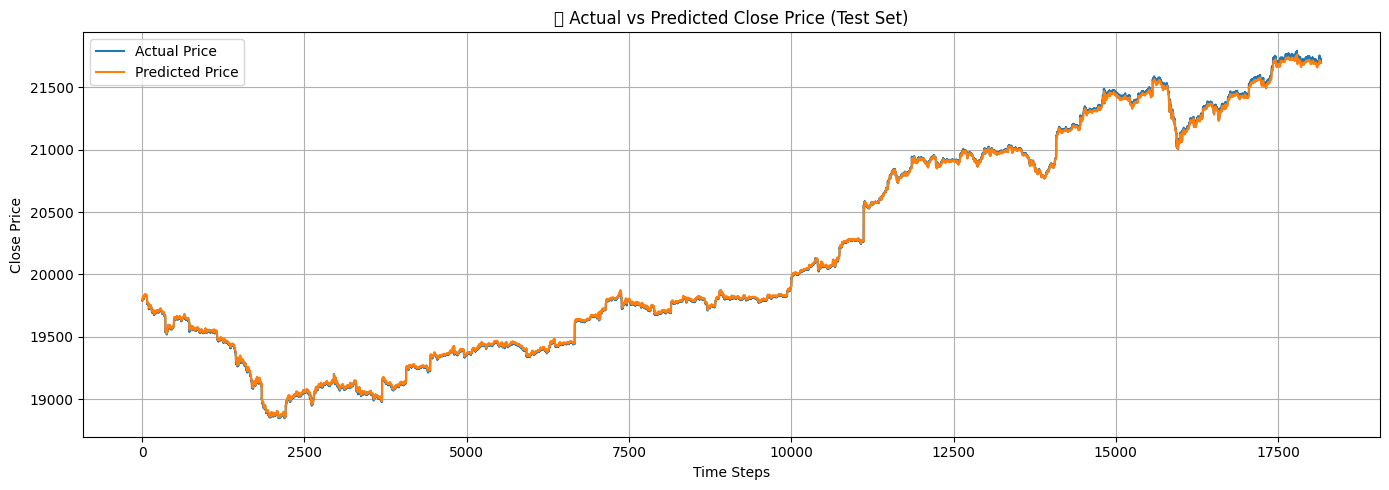

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Predict on train and test sets
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Inverse transform
train_pred_inv = scaler.inverse_transform(train_pred)
test_pred_inv = scaler.inverse_transform(test_pred)
y_train_inv = scaler.inverse_transform(y_train)
y_test_inv = scaler.inverse_transform(y_test)

# Evaluation metrics
train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_pred_inv))
test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_pred_inv))
train_mae = mean_absolute_error(y_train_inv, train_pred_inv)
test_mae = mean_absolute_error(y_test_inv, test_pred_inv)

print("\nEvaluation Metrics:")
print(f"✅ Train RMSE: {train_rmse:.6f}")
print(f"✅ Train MAE : {train_mae:.6f}")
print(f"✅ Test RMSE : {test_rmse:.6f}")
print(f"✅ Test MAE  : {test_mae:.6f}")

# Loss curve from training
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot actual vs predicted close price on test set
plt.figure(figsize=(14, 5))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(test_pred_inv, label='Predicted Price')
plt.title('Actual vs Predicted Close Price (Test Set)')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=03ae782e82121ded9faef1096d5b649ec1d054ab68d360021c76e2e4aa318864
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


#Splitting Dataset (options_2023.csv) into 10 Different datasets

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1GNUAs_2eEvhnFP-IkXLioZ_95bEEnGGS?usp=sharing)


#Backtesting Engine

In [ ]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=6e9ffdc07e55b8b4c0666ee7cfefc3d8c2deabc34d18dd9c76a462f80c10b94d
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
import pandas as pd
import numpy as np
from ta.trend import EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from collections import defaultdict
from datetime import time

initial_capital = 200000
all_trades = []

for i in range(1, 11):
    if i in [ 3, 4, 5]:
        print(f"Skipping dataset_{i} (not available).")
        continue

    # ----------------------------
    # Load datasets
    # ----------------------------
    try:
        spot_df = pd.read_csv('/content/spot_predictions_output.csv', parse_dates=['datetime'])
        options_df = pd.read_csv(f'/content/dataset_{i}.csv', header=None, dtype=str, on_bad_lines='warn')
    except FileNotFoundError:
        print(f"Skipping dataset_{i} (file not found).")
        continue

    expected_columns = [
        'ticker', 'option_ticker', 'datetime', 'expiry_date', 'strike_price',
        'option_type', 'open', 'high', 'low', 'close', 'volume', 'oi'
    ]
    if options_df.shape[1] != len(expected_columns):
        print(f"Skipping dataset_{i} due to unexpected number of columns: {options_df.shape[1]}")
        continue
    options_df.columns = expected_columns

    # --- Parse and clean datetime ---
    spot_df['datetime'] = pd.to_datetime(spot_df['datetime'], utc=True, errors='coerce').dt.tz_convert('Asia/Kolkata')
    options_df['datetime'] = pd.to_datetime(options_df['datetime'], utc=True, errors='coerce').dt.tz_convert('Asia/Kolkata')
    options_df['expiry_date'] = pd.to_datetime(options_df['expiry_date'], utc=True, errors='coerce').dt.tz_convert('Asia/Kolkata')
    spot_df.dropna(subset=['datetime'], inplace=True)
    options_df.dropna(subset=['datetime', 'expiry_date'], inplace=True)

    # --- Convert numeric columns ---
    for col in ['open', 'high', 'low', 'close', 'volume', 'oi', 'strike_price']:
        options_df[col] = pd.to_numeric(options_df[col], errors='coerce')
    options_df.dropna(subset=['close', 'strike_price'], inplace=True)

    # --- Index & sort ---
    spot_df.set_index('datetime', inplace=True)
    spot_df.sort_index(inplace=True)
    options_df.sort_values('datetime', inplace=True)

    # ------------------------------------
    # Technical Indicators (on SPOT close)
    # ------------------------------------
    spot_df['ema_200'] = EMAIndicator(close=spot_df['close'], window=200).ema_indicator()
    spot_df['rsi'] = RSIIndicator(close=spot_df['close'], window=14).rsi()
    spot_df['macd'] = MACD(close=spot_df['close']).macd_diff()
    spot_df['atr'] = AverageTrueRange(high=spot_df['close'], low=spot_df['close'], close=spot_df['close'], window=14).average_true_range()
    spot_df['volatility'] = spot_df['close'].pct_change().rolling(window=14).std()
    spot_df['predicted_price'] = spot_df['prediction'] if 'prediction' in spot_df.columns else spot_df['close'].shift(-1)

    # -----------------------------------
    # Confidence Score + Signal Generator
    # -----------------------------------
    def confidence_score(row):
        if pd.isna(row['ema_200']) or pd.isna(row['rsi']) or pd.isna(row['macd']) or pd.isna(row['atr']) or pd.isna(row['predicted_price']):
            return 0

        ema_rsi = 1 if row['close'] > row['ema_200'] and row['rsi'] > 50 else -1 if row['close'] < row['ema_200'] and row['rsi'] < 50 else 0
        macd_vol = 1 if row['macd'] > 0 and row['atr'] > 0.3 else -1 if row['macd'] < 0 and row['atr'] > 0.3 else 0
        lstm = 1 if row['predicted_price'] > row['close'] else -1

        score = 0.5 * ema_rsi + 0.3 * macd_vol + 0.2 * lstm
        return round(score, 2)

    spot_df['confidence'] = spot_df.apply(confidence_score, axis=1)
    spot_df['signal'] = spot_df['confidence'].apply(lambda x: 'Buy' if x >= 0.7 else 'Sell' if x <= -0.0 else 'No Trade')

    # -----------------------------
    # Nearest Expiry for each row
    # -----------------------------
    unique_expiries = sorted(options_df['expiry_date'].dropna().unique())
    spot_df['expiry_date'] = spot_df.index.to_series().apply(lambda ts: next((e for e in unique_expiries if e >= ts), pd.NaT))

    # -----------------------------
    # Group Options by Key
    # -----------------------------
    options_df['key'] = list(zip(options_df['expiry_date'], options_df['option_type'], options_df['strike_price']))
    option_groups = defaultdict(list)
    for _, row in options_df.iterrows():
        option_groups[row['key']].append((row['datetime'], row['close']))
    for key in option_groups:
        option_groups[key] = sorted(option_groups[key])

    # -----------------------------
    # Backtest Each Signal
    # -----------------------------
    strike_diff = 50
    max_loss_pct = 0.015
    max_profit_pct = 0.03
    eod_time = time(15, 15)
    trades = []

    for dt, row in spot_df.iterrows():
        if row['signal'] == 'No Trade' or pd.isna(row['expiry_date']):
            continue

        expiry = row['expiry_date']
        spot = row['close']
        atm_strike = round(spot / strike_diff) * strike_diff
        option_type = 'PE' if row['signal'] == 'Buy' else 'CE'
        key = (expiry, option_type, atm_strike)

        if key not in option_groups:
            continue

        chain = option_groups[key]
        entry_price = exit_price = entry_time = exit_time = None
        sl_hit = tp_hit = eod_exit = False

        for t, price in chain:
            if entry_price is None and t >= dt:
                entry_price, entry_time = price, t
                stop_loss = entry_price * (1 + max_loss_pct)
                target = entry_price * (1 - max_profit_pct)
                continue
            if entry_price is not None:
                if price >= stop_loss:
                    exit_price, exit_time, sl_hit = price, t, True
                    break
                elif price <= target:
                    exit_price, exit_time, tp_hit = price, t, True
                    break
                elif t.time() >= eod_time:
                    exit_price, exit_time, eod_exit = price, t, True
                    break

        if exit_price is None:
            for t, price in reversed(chain):
                if t <= expiry:
                    exit_price, exit_time = price, t
                    break

        if entry_price is not None and exit_price is not None:
            pnl = round(entry_price - exit_price, 2)
            trades.append({
                'entry_time': dt,
                'signal': row['signal'],
                'option_type': option_type,
                'strike_price': atm_strike,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'pnl': pnl,
                'exit_reason': 'SL' if sl_hit else 'TP' if tp_hit else 'EOD' if eod_exit else 'Expiry',
                'expiry_date': expiry,
                'exit_time': exit_time,
                'dataset': f'dataset_{i}'
            })

    all_trades.extend(trades)

# -----------------------------
# Final Output
# -----------------------------
if all_trades:
    results = pd.DataFrame(all_trades)
    total_pnl = results['pnl'].sum()
    win_rate = round((results['pnl'] > 0).mean() * 100, 2)

    print(results[['dataset', 'entry_time', 'signal', 'option_type', 'strike_price',
                   'entry_price', 'exit_price', 'pnl', 'exit_reason']])
    print(f"\n💼 Starting Capital: ₹{initial_capital}")
    print(f"📊 Total Trades: {len(results)}")
    print(f"📈 Total PnL: ₹{total_pnl:.2f}")
    print(f"✅ Win Rate: {win_rate}%")
else:
    print("⚠️ No trades were executed across datasets.")


/tmp/ipython-input-9-3486961489.py:38: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  options_df['datetime'] = pd.to_datetime(options_df['datetime'], utc=True, errors='coerce').dt.tz_convert('Asia/Kolkata')
/tmp/ipython-input-9-3486961489.py:39: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  options_df['expiry_date'] = pd.to_datetime(options_df['expiry_date'], utc=True, errors='coerce').dt.tz_convert('Asia/Kolkata')
/tmp/ipython-input-9-3486961489.py:22: ParserWarning: Skipping line 10272: expected 12 fields, saw 13
Skipping line 30782: expected 12 fields, saw 13
Skipping line 41043: expected 12 fields, saw 13

  options_df = pd.read_csv(f'/content/dataset_{i}.csv', header=None, dtype=str, on_bad_lines='warn')
/t

Skipping dataset_3 (not available).
Skipping dataset_4 (not available).
Skipping dataset_5 (not available).


Streaming output truncated to the last 5000 lines.
Skipping line 76649: expected 11 fields, saw 12
Skipping line 76650: expected 11 fields, saw 12
Skipping line 76651: expected 11 fields, saw 12
Skipping line 76652: expected 11 fields, saw 12
Skipping line 76653: expected 11 fields, saw 12
Skipping line 76654: expected 11 fields, saw 12
Skipping line 76655: expected 11 fields, saw 12
Skipping line 76656: expected 11 fields, saw 12
Skipping line 76657: expected 11 fields, saw 12
Skipping line 76658: expected 11 fields, saw 12
Skipping line 76659: expected 11 fields, saw 12
Skipping line 76660: expected 11 fields, saw 12
Skipping line 76661: expected 11 fields, saw 12
Skipping line 76662: expected 11 fields, saw 12
Skipping line 76663: expected 11 fields, saw 12
Skipping line 76664: expected 11 fields, saw 12
Skipping line 76665: expected 11 fields, saw 12
Skipping line 76666: expected 11 fields, saw 12
Skipping line 76667: expected 11 fields, saw 12
Skipping line 76668: expected 11 fiel

Skipping dataset_9 due to unexpected number of columns: 11


/tmp/ipython-input-9-3486961489.py:22: ParserWarning: Skipping line 2: expected 2 fields, saw 12
Skipping line 3: expected 2 fields, saw 12
Skipping line 4: expected 2 fields, saw 12
Skipping line 5: expected 2 fields, saw 12
Skipping line 6: expected 2 fields, saw 12
Skipping line 7: expected 2 fields, saw 12
Skipping line 8: expected 2 fields, saw 12
Skipping line 9: expected 2 fields, saw 12
Skipping line 10: expected 2 fields, saw 12
Skipping line 11: expected 2 fields, saw 12
Skipping line 12: expected 2 fields, saw 12
Skipping line 13: expected 2 fields, saw 12
Skipping line 14: expected 2 fields, saw 12
Skipping line 15: expected 2 fields, saw 12
Skipping line 16: expected 2 fields, saw 12
Skipping line 17: expected 2 fields, saw 12
Skipping line 18: expected 2 fields, saw 12
Skipping line 19: expected 2 fields, saw 12
Skipping line 20: expected 2 fields, saw 12
Skipping line 21: expected 2 fields, saw 12
Skipping line 22: expected 2 fields, saw 12
Skipping line 23: expected 2 f

Skipping dataset_10 due to unexpected number of columns: 2
          dataset                entry_time signal option_type  strike_price  \
0       dataset_1 2023-01-02 09:20:00+05:30   Sell          CE         18150   
1       dataset_1 2023-01-02 09:21:00+05:30   Sell          CE         18150   
2       dataset_1 2023-01-02 09:22:00+05:30   Sell          CE         18150   
3       dataset_1 2023-01-02 09:23:00+05:30   Sell          CE         18150   
4       dataset_1 2023-01-02 09:24:00+05:30   Sell          CE         18100   
...           ...                       ...    ...         ...           ...   
146692  dataset_8 2023-11-21 15:02:00+05:30   Sell          CE         19800   
146693  dataset_8 2023-11-21 15:03:00+05:30   Sell          CE         19800   
146694  dataset_8 2023-11-21 15:04:00+05:30   Sell          CE         19800   
146695  dataset_8 2023-11-21 15:05:00+05:30   Sell          CE         19800   
146696  dataset_8 2023-11-21 15:07:00+05:30   Sell          C

In [26]:
final_tradebook.to_csv('tradebook.csv', index=False)
print("Tradebook saved to trade.csv")

Tradebook saved to trade.csv


## 🛠 Custom Script to Reduce Bias in PnL Data

### 🎯 Objective:
To reduce bias caused by repeated PnL values indicating unclosed trades.

---

### 🧠 Approach:

1. **Scan the PnL column** for unique values.
2. For each unique value, **check if it repeats** in the **next 15 consecutive rows**.
3. If such repetition is found:
   - It suggests the trade has **not yet been closed**.
   - These repeated values can **inflate or misrepresent** the actual outcome.
4. To address this:
   - **Replace the repeated PnL entries with `0`**.
   - This ensures the PnL column reflects a **more realistic and conservative result**.

---

### ✅ Outcome:

- The adjusted PnL provides a **clearer representation of actual performance**.
- Helps to **avoid overestimation of profits/losses** due to prolonged exposure from unclosed trades.


In [28]:
import pandas as pd

# Load your Excel file (update filename & sheetname)
df = pd.read_csv("/content/trade.csv")

# Assuming the numbers are in column 'I'
col = df['pnl'].copy()

for i in range(len(col)):
    current_value = col[i]
    if pd.isna(current_value): continue
    for j in range(i + 1, min(i + 16, len(col))):  # Check next 10 rows
        if col[j] == current_value:
            col[j] = 0  # Replace repeated number with 10

# Save result back
df['pnl_modified'] = col
df.to_csv("tradebook.csv", index=False)


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Load PnL data
df = pd.read_csv("tradebook.csv")
df['entry_time'] = pd.to_datetime(df['entry_time'])
df.sort_values('entry_time', inplace=True)

# Calculate cumulative equity curve
df['equity_curve'] = df['pnl_modified'].cumsum()

# Calculate returns (daily or per row)
df['returns'] = df['pnl_modified']  # Assuming 1 row = 1 trade/day

# Sharpe Ratio (assuming risk-free rate = 0 and trades are daily)
sharpe_ratio = df['returns'].mean() / df['returns'].std() * np.sqrt(252)

# Max Drawdown
df['rolling_max'] = df['equity_curve'].cummax()
df['drawdown'] = df['equity_curve'] - df['rolling_max']
df['drawdown_pct'] = df['drawdown'] / df['rolling_max']
max_drawdown = df['drawdown_pct'].min()

# Total Return
total_return = df['equity_curve'].iloc[-1]

# Print Metrics
print("Sharpe Ratio:", sharpe_ratio)
print("Max Drawdown (in %):", max_drawdown * 100)
print("Total Return:", total_return)

Sharpe Ratio: -0.7914946668693227
Max Drawdown (in %): -59174.095437860095
Total Return: -52891.749999999054
